In [1]:
import pandas as pd
import ms3 
from  ms3.utils import *
import os 
from ms3 import Score
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import numpy as np
from scipy import stats
import pretty_midi
import statistics
import torch.nn
from torch import nn
from torch.optim import SGD

# include directory 
home_dir = '/Users/Pushkar/PycharmProjects/Tresillo/'

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Towards a Rhythmical Definition of the Tressilio beat and a Tracing of it in Popular Music 

## 1) Introduction & Research Question 

### 1.1) Research question: 
"Can we compute to which extent a defined rhythm, which we refer to as Tresillo rhythm, is used in a given pop song and if so can we measure the intensity of Tresillo rhythm use in top-20-billboard songs over the past twenty years?"  

**Discussion:**  
In our project we would like to discuss the use of a rhythm, which we refer to as 'Tresillo rhythm', in the popular music of the last 20 years. We define this rhythm in our project, given secondary literature, and thus obtain a precise notation and formulization of the Tresillo rhythm. Given this definition we can then compute the similarity between the Tresillo rhythm and the rhythm of a given pop song. Thus, we hope to obtain a similarity coefficient which measures how similar the rythm of a given pop song is to our self defined Tresillo rythm. Given the computed similarity coefficients, we hope to measure the use of the Tresillo rhythm in the top 20 billboard songs of the past 20 years (1999-2019).


### 1.2) Assumptions

- The pop songs found in the billboard charts mostly come with a simple melodic and rhythmic structure without a lot of variation troughout the song. We assume that for most pop songs present in the billboard charts, one can identify one dominant rhythm per song.
- For our presntation of songs in rhythm space, we also assume that the majority of the songs in the billboard charts is in the time signature of 4/4. Our data exploration justifies this assumption. Nine out of 442 songs in the dataset are in 3/4 or 6/8, those are not considered in the analysis. 
- We assume that a time sample of about 30 seconds is suitable to present the main rythm of a pop song. This assumptions is related to the difficultys of finding puplic available midi data for recent pop music. While we couldn't find a data source providing the midi data of the full songs, we managed to find midi data for shorter samples of the songs. The average sample length is 44.1 sec.
    

### 1.3) Data Representation
Initially our data is represented in the MIDI file format. The representation of music in the MIDI format has the advantage, that often several voices of different instruments are represented in such files. In contrast to musescore, where often only the voice of one instrument (mostly piano) is notated.  
However, to obtain a list of onsets of every musical event in a given song, we have to convert our MIDI (.midi) files to Musescore (.mscx) files.  
To convert and further analyze our files, we will use the [ms3](https://pypi.org/project/ms3/) python library.  
To convert a directory of .midi files to .mscx files we use following command:


In [ ]:
path_midi = home_dir + 'dataset/project_midi/tresillo/'
target = home_dir + 'dataset/project_mscx/mscx_tresillos_billboard/'

dir_list = os.listdir(path_midi)

for el in dir_list:
    convert(path_midi+el, target+el[:-4]+'.mscx', MS='musescore3')

**TA instructions**: Precision of Research Question

- State the final version of your research question as you understand it now.

-  Make all assumptions and hypotheses explicit.

- In case Milestone 2 did not include the final data representation that you are analyzing, present the representation you finally used and the necessary steps to get to it.

**Thoughts Aurel:** 
 - Reasearch Question: Move to a fuzzy definition of Tresillio-ness: E.g.: 
    Are pop songs increasingly using a rythm pattern which is similar to a rythm pattern which we reffer to as 'Tresillio rythm'?  
    
 - Assumptions are very important for them. Here we have to note our definition(s) of the Tresillio rythm pattern and how we derive them (incl sources). Furthermore, we have to discuss cases where there are Rythms which are similar to the Tresillio rythm but not equivalent (e.g.: reggaeton) and how we deal with them computationally.  
 
 - Here we have to discuss the conversion of our MIDI files to the musescore3 file format. Furthermore, we have to discuss what the musescore3 format offers us, and why it is the better choice for our analysis. 
 
  **Toughts Florian:**
    -Assumptions:
    
    -30 second piece of pop song is suitable to identfy the main rythm
    
    -Main rythm can be identified by counting the onsets
    
    -the great majority of pop songs comes in 4/4 (not shure if we really need that assumption)
    

## 2) Methods

### 2.1) Definition of the Tresillo rhythm
We notate a clean version of a rhythm wich we from now on use as our defintion for the clean tresillo rhythm, in the following context also called tresillo template(see also (Floyd, 1999)).

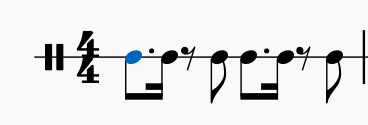

The rhythm pattern consists of a dotted eighth note, followed by a sixteenth note, an eighth rest and an eighth note and is repeated two times in a 4/4 bar. The rytm pattern is beeing used as a own rythm or as a rythmic part of a more complex rythm, for example the "clave" pattern or the ragaetton rythm (Toussaint, 2004).
By notating the rythm in MuseScore 3 and saving it as a .mscx file, we can use it our data processing pipeline described in the following sections.

### 2.2) Rhythm histograms and vectors 

To be able to measure the similarity between rhythm we must have a clear definition and thus following representation of rhythm. In general, one can define rhythm as "a series of onsets and durations of musical events.” (Rohrmeier, 2020). In our specific case however, we are interested in the dominat and repeating rhythm of a given song. Therefore we prefer a narrower definition of rhythm as “repeated recurrences in alternate heavy and light beats” (Chin and Wu, 1992). To furthermore simplify our data, we assume that the main rhythm of a song can be defined by the onsets  of its musical events (notes).  
To obtain a representation of the dominate rhythm of a song, we preceed to aggregate all musical onset to one bar. Collapsing all musical onsets to one bar and thus obtaining onset 'histograms' is a common pratice and has been used beside others to analyze western classical music (Palmer and Krumhansl, 1990) and american folk music (Huron and Ommen, 2006). 
With the onset histogram of a song we can compile a n dimensional vector for each song, which we refer to as a 'rhythm vector'. Given that the number of songs with meters other than 4/4 is negible, we only consider songs with a 4/4 meter in our analysis.  Given that we only consider songs with 4/4 meters, we obtain for each song a 16 dimensional vector. 




### 2.3) Evaluating different similarity measures 
In this section we try out different similarity measures to choose the best one. A good similarity measure would have a high similarity for all songs which have a tresillo pattern and a low similarity for songs which do not have such a pattern.
To measure this, we use 'Similarity Goodness' $S^*$, which is the ratio of mean similarity in songs which have tresillo and mean similarity of songs which don't.
\begin{equation}
S^* = \frac{\frac{\sum{\text{similarity(Songs with tresillo)}}}{n}}{\frac{\sum{\text{similarity(Songs without tresillo)}}}{m}}
\end{equation}
`n` and `m` denote the number of songs in each of respective categories. 

In each of the subsections we calculate relavant statistics by dividing the similarity methods based on the following techniques
* Template based center vs Centroid computed from known tresillo songs
* Parameterized vs non parameterized distance function

Each subsection in section 3 will contains the mean similarity and it's standard deviation.

At the end of the section we compare the $S^*$ (Model Goodness) for all of the above subsections.

_NOTE: Both the datasets used to evaluate $S^*$ are from the validation/test set and not used as part of training/finding the centroid._


#### 2.3.1) Rhythm similarity measured with cosine simularity, using tresillo template as centre.
Given the 16 dimensional rhythm vectors we obtain following the methode described above, we can now compute simple similarity metrics.  
In rhythm analysis a common similarity metric which is used to calculate the similarity between two rhythm vectors is the cosine distance (see: Panteli et al., 2014; Parry and Essa, 2003).  The cosine similarity metric is scale invariante, which as such is interesting for rhythm similarity given that thus only relative frequencies of onsets are important and not absolute frequencies.  
The cosine distance between two vectors A and B is defined as following: 
\begin{equation}
\cos ({\bf A},{\bf B})= {{\bf A}*{\bf B} \over \|{\bf A}\| \|{\bf B}\|} = \frac{ \sum_{i=1}^{n}{{\bf a}_i{\bf b}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf a}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf b}_i)^2}} }
\end{equation}

Given the definition of the cosine similarity we can now compute the similarity between our self defined Tresillo rhythm and the billboard songs.  
First, however we will validate this similarity metric by testing it on our self compiled list of songs which do comprise a Tresillo rhythm and songs which do not comprise a Tresillo rhythm. We then compute the mean 'Tresillo-ness' (similarity to Tresillo rhythm) of both samples. By employing the Bootstrapping method we can also obtain a measurement of uncertainty, as provided by 2.5% and 97.5% confidence intervals.

#### 2.3.2) Rhythm similarity measured with cosine simularity, using the centroid of tresillo songs as centre.

We compute the centroid by taking the mean of all the tresillo song vectors. This centroid is then used as the centre of `tresillo-ness` in the model. The cosine similarity is the same as 2.3.1.

\begin{equation}
\text{centroid}_i = \frac{\underset{j:= \text{1 to n}}\sum{A_{i}^{j}}}{n}
\end{equation}

Where,
* $\textbf{centroid}_i$ is the ith dimension of the centroid.
* $A^j$ is the $j^{th}$ song

#### 2.3.3) Rhythm similarity measured with parameterized cosine simularity, using tresillo template as centre.


In 2.3.5 and 2.3.6, we define a parameterized model for computing the similarity between tresillo and the tresillo-ness center.
We define the parameterized cosine similarity
\begin{equation}
\cos_{\Theta} ({\bf A},{\bf B})= {{\bf A_{\Theta}}*{\bf B_{\Theta}} \over \|{\bf A_{\Theta}}\| \|{\bf B_{\Theta}}\|} = \frac{ \sum_{i=1}^{n}{{\bf a}_i.{\theta_i}{\bf b}_i.{\theta_i}} }{ \sqrt{\sum_{i=1}^{n}{({\bf a}_i.{\theta_i})^2}} \sqrt{\sum_{i=1}^{n}{({\bf b}_i.{\theta_i})^2}} }
\end{equation}

We learn this theta by optimizing the over the objective function
\begin{equation}
\underset{\Theta}{\mathrm{argmin}} \frac{cos_{\Theta}(A', T)}{cos_{\Theta}(A, T)}
\end{equation}

Where,
* **A'** is the set of songs with tresillo __not__ present in them
* **A** is the set of songs with tresillo present in them
* **T** is the center point for tresilloness. In this case it is the vector corresponding to the template tresillo vector described in 
* $\textbf{cos}_{\Theta}$(*) is the parameterized cosine similarity

We use the validation set for both A' and A to avoid overfitting in the model.

#### 2.3.4) Rhythm similarity measured with parameterized cosine simularity, using the centroid of tresillo songs as centre.


## 3) Final Results

### 3.1) Onset histograms and rhythm vectors 
In this first part we will use onset histograms to compute rhythm vectors.  
To obtain the onset histogram of a given song, we use the notes representation provided by the [ms3](https://pypi.org/project/ms3/) libary and colapse all musical onsets to one bar. In the example below we will compile the histograms for our self defined 'Vanilla Tresillo' and for the example song 'shape of you' by Ed Sheran. Then we will proceed to compute the rhythm vectors for both songs

Text(0.5, 1.0, 'Vanilla Tresillo')

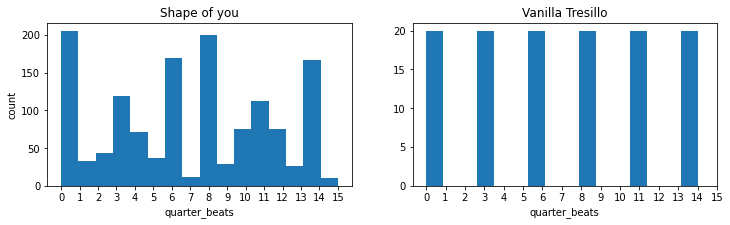

In [4]:
#paths to both examples
shape_of_you = home_dir+'dataset/project_mscx/mscx_tresillos_billboard/Shape of you-Ed Sheran.mscx'
vanilla_tresillo = home_dir+'dataset/project_mscx/mscx_tresillos/Vanilla_Tresillo.mscx'


# get the note scores of both examples 
df_shape_of_you = Score(shape_of_you).mscx.notes
df_vanilla_tresillo = Score(vanilla_tresillo).mscx.notes

#calculate quarter note position for each note
df_shape_of_you['quarter_beats'] = (df_shape_of_you.mc_onset*16).astype('int32')
df_vanilla_tresillo['quarter_beats'] = (df_vanilla_tresillo.mc_onset*16).astype('int32')


fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].hist(df_shape_of_you['quarter_beats'], bins=16)
ax[1].hist(df_vanilla_tresillo['quarter_beats'], bins=16)
ax[0].set_xlabel('quarter_beats')
ax[1].set_xlabel('quarter_beats')
ax[0].xaxis.set_ticks(np.arange(0, 16, 1))
ax[1].xaxis.set_ticks(np.arange(0, 16, 1))
ax[0].set_ylabel('count')
ax[0].set_title('Shape of you')
ax[1].set_title('Vanilla Tresillo')

#mention somewhere that we are working with quarter notes 

In a next step we want to compile rhythm of each song given this notion of histograms. E.g: every dimension incorporates the absolute frequency of onsets on one given quarter note. This is done as follows:

In [5]:
rhythm_vector_shape_you = df_shape_of_you.groupby(['quarter_beats'])['mn'].agg(['count'])
rhythm_vector_shape_you  = rhythm_vector_shape_you.reindex(list(range(0,16)),fill_value=0).T
rhythm_vector_shape_you 

quarter_beats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,206,33,44,119,72,37,169,12,200,29,75,112,75,27,167,10


In the assumption that the rhythm vectors of distinct voices within a song might include information we want to preserve, we compiled one rhythm vector per instrument in a song as follows:

In [6]:
# Define instruments 
shape_of_you_score = Score(shape_of_you)
instrument_dict = {}
for key in shape_of_you_score.mscx.metadata['parts']:
    for staff in shape_of_you_score.mscx.metadata['parts'][key].keys():
            instrument_dict[staff] = key


#staff to voice/instruments 
df_shape_of_you['instrument'] = [instrument_dict[el] if el in instrument_dict else 'na' for el in df_shape_of_you.staff]

#compute rhythm vectors per voice
rhythm_vector_shape_you_instruments = df_shape_of_you.groupby(['instrument','quarter_beats'])['mn'].agg(['count'])
rhythm_vector_shape_you_instruments = rhythm_vector_shape_you_instruments.groupby(level=0).apply(lambda x: x.reset_index(level = 0).drop(['instrument'],axis=1).reindex(list(range(0,16)),fill_value=0).T)
rhythm_vector_shape_you_instruments = rhythm_vector_shape_you_instruments.reset_index()
rhythm_vector_shape_you_instruments

quarter_beats,instrument,level_1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Grand Piano,count,66,0,0,0,0,0,0,0,66,0,0,0,0,0,0,0
1,"Marimba, untitled",count,66,0,0,53,14,0,63,0,68,0,0,57,17,0,63,0
2,Melodic Drum,count,0,0,33,36,13,19,39,0,0,0,50,28,10,19,38,0
3,Overdrive Gtr,count,6,2,1,1,4,4,6,2,6,1,6,2,6,1,6,0
4,Percussion,count,24,23,0,2,19,2,22,2,21,21,1,2,19,2,23,2
5,Tenor Sax,count,20,8,10,8,16,12,16,8,16,7,18,6,15,5,14,8
6,Woodblock,count,2,0,0,2,0,0,2,0,2,0,0,1,2,0,2,0
7,Xylophone,count,22,0,0,17,6,0,21,0,21,0,0,16,6,0,21,0


If we want to compile rhythm vectors (per voice) for all mscx files in one directory we can use following loop:

In [ ]:
def rythm_vectors(in_dir, out_dir):
    list_sheet_music = os.listdir(in_dir)
    df_rythm_vectors =[]

    for idx, el in enumerate(list_sheet_music):
        if el[-4:] == 'mscx':

            
            #Get notes with onsets
            s = Score(dir_sheet_music+el)
            df = s.mscx.notes

            # Define instruments 
            instrument_dict = {}
            for key in s.mscx.metadata['parts']:
                for staff in s.mscx.metadata['parts'][key].keys():
                    instrument_dict[staff] = key


            #staff to instruments 
            df['instrument'] = [instrument_dict[el] if el in instrument_dict else 'na' for el in df.staff]


            # define quarter beat 
            df['quarter_beats'] = (df.mc_onset*16).astype('int32')


            #make rythm matrix & data frame
            df_histogram = df.groupby(['instrument','quarter_beats'])['mn'].agg(['count'])
            df_histogram = df_histogram.groupby(level=0).apply(lambda x: x.reset_index(level = 0).drop(['instrument'],axis=1).reindex(list(range(0,16)),fill_value=0).T)
            df_histogram = df_histogram.reset_index()

            df_histogram.insert(loc=0, column='song_artist', value=el[:-5])

            #concat to big rythm vector df
            if len(df_rythm_vectors) == 0: df_rythm_vectors = df_histogram

            df_rythm_vectors = pd.concat([df_rythm_vectors,df_histogram], axis=0)

    df_rythm_vectors.to_csv(out_dir, index = False)

    
dir_sheet_music = home_dir + '/dataset/project_mscx/mscx_billboard/'
out_dir = home_dir + '/dataset/rythm_vectors/rythm_vectors_billboard.csv'
rythm_vectors(dir_sheet_music, out_dir)

### 3.2) Tresilio-ness with Cosine Similarity
In a first naive analysis we will employ the cosine similarity measurement to assess if the vector of a given song is similar to our defined Tresillo rhythm. We will need some helper functions.    
Following two helper functions will help us to collapse all rhythms of all instruments to one rhythm vector per song.  
The second function calculates the cosine similarity between a pandas data frame of rhythm vectors and one single rhythm vector.  
The third function calculates the 2.5% and the 97.5% confidence intervals of the distribution of a mean of a given data set. This function will allow us to assess, how big the uncerntaingty is in our data set and if the means of two distributions are indeed significantly different.

In [86]:
def calc_cosine_sim(rythm_vectors, tresillo_vector, model):
    rythm_vectors['cosine_sim_tresillo'] = cosine_similarity(rythm_vectors.to_numpy()[:,:16],tresillo_vector).cpu().detach().numpy()
    return rythm_vectors

def calc_cosine_sim_model(rythm_vectors, tresillo_vector, model):
    rythm_vectors['cosine_sim_tresillo'] = model.similarity(rythm_vectors.to_numpy()[:,:16],tresillo_vector).cpu().detach().numpy()
    return rythm_vectors


def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

Now lets read in the rhythm vector of our Tresillo template.

In [87]:
df_synt_tresillo = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillio.csv') # read in all defined 'tresillos' and variations
df_vanilla_tresillo = df_synt_tresillo[df_synt_tresillo['song_artist']=='Vanilla_Tresillo'].loc[: ,"0":"15"] # only use the 16d vector of our vanilla_tresillo
vector_vanilla_tresillo = np.asarray(df_vanilla_tresillo)
vector_vanilla_tresillo

array([[20,  0,  0, 20,  0,  0, 20,  0, 20,  0,  0, 20,  0,  0, 20,  0]])

We will now calculate the cosine similarity between our Tresillo template vector and between a hand selected set of Tresillo songs.  
This set of songs has been selected by us ourself and none of those 'validation' songs  are included in the billboard data sets.

In [88]:

tresillo_test_set_vectors = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillo_not_billboard.csv')
#tresillo_test_set_vectors = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillos_billboard.csv')
tresillo_test_set_vectors = collapse_normalize_vectors(tresillo_test_set_vectors)
tresillo_test_set_vectors = calc_cosine_sim(tresillo_test_set_vectors, vector_vanilla_tresillo, model)
print(tresillo_test_set_vectors['cosine_sim_tresillo'])

song_artist
Chandelier Sia                             0.228934
Cold Water Major Lazer                     0.788653
Hips Don't Lie Shakira                     0.567019
I Don't Care Ed Sheeran & Justin Bieber    0.798558
One Dance - Drake & Wizkid, Kyla Reid      0.276096
Sorry Justin Bieber                        0.734520
Name: cosine_sim_tresillo, dtype: float64


Let's calculate the mean Tresillo-ness and also the 2.5% and 97.5% confidence intervals of the mean as obtained by bootstrapping.

In [89]:
print('mean Tresillo-ness in the test set: ', tresillo_test_set_vectors['cosine_sim_tresillo'].mean())
lower_tresillo_ci, upper_tresillo_ci = bootstrap_CI(tresillo_test_set_vectors['cosine_sim_tresillo'], 100)
print('tresillo upper and lower ci on 100 draws: ', lower_tresillo_ci, upper_tresillo_ci)

mean Tresillo-ness in the test set:  0.5656300543070706
tresillo upper and lower ci on 100 draws:  0.36541404042960046 0.7279494819720806


Let's do exact same thing, but with a comparison data set of songs which we kno to not include any Tresillo songs.  
Also calculating the mean and the confidence intervals of the not Tresillo songs.

In [90]:
non_tresillio_vectors =  pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_not_tresillo_validation.csv')
#non_tresillio_vectors = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_no_tresillos_4_4.csv')

non_tresillio_vectors = collapse_normalize_vectors(non_tresillio_vectors)
non_tresillio_vectors = calc_cosine_sim(non_tresillio_vectors, vector_vanilla_tresillo, model)
print(non_tresillio_vectors['cosine_sim_tresillo'])

print('mean Tresillo-ness in the test set: ', non_tresillio_vectors['cosine_sim_tresillo'].mean())
lower_non_tresillo_ci, upper_non_tresillo_ci = bootstrap_CI(non_tresillio_vectors['cosine_sim_tresillo'], 100)
print('tresillo upper and lower ci on 100 draws: ', lower_non_tresillo_ci, upper_non_tresillo_ci)

song_artist
Dress You Up           0.068071
Fear of the Dark       0.278240
Folsom Prison Blues    0.368821
Immigrant Song         0.492565
Jailhouse Rock         0.213119
One Step Closer        0.112430
Sweet Child O'Mine     0.291270
Sweet Home Alabama     0.147365
Name: cosine_sim_tresillo, dtype: float64
mean Tresillo-ness in the test set:  0.24648528426233218
tresillo upper and lower ci on 100 draws:  0.1624387014140919 0.3466855120316754


Already looking at the means of the two samples and their confidence intervalls, they seem to be significantly different.  
However let's also calculate the t-test statistics to ensure that the distributions are actually different.

In [91]:
ttest_pvalue = stats.ttest_ind(tresillo_test_set_vectors['cosine_sim_tresillo'], non_tresillio_vectors['cosine_sim_tresillo']).pvalue
print('p value that the means are the same: ', ttest_pvalue)

p value that the means are the same:  0.011291374896669634


**Discussion:**  
Looking at the the Tresillio cosine similarity metrics of both data sets and comparing the distributions of the means to each other (confidence intervals and t-test), we see that their mean Tresillo-ness is indeed significantly diffferent.  
However, we also see that 1) this Tresillo-ness measurement seems to be quite noisy 2) The distribution of the two samples are not as far apart as we would like them to be.  
The noisiness of this metric, can be especially seen, if one looks at the individual cosine Tresillo-ness values of the songs. Here we see that there is great variance in Tresillo-ness in the hand selected Tresillo data set. Values can be as small as 0.6, which corresponds to the value of a none Tresillo song.  
Furthermore, it seems that also songs wich we classified to have no Tresillo, have a cosine Tresillo-ness up to 0.72.  
In general we can state that the cosine similarity methods seems to identify a ceratin Tresillo-ness, however it is questionable how robust this method is.

### 3.3) Different models to find similarity with tresillo. 
As described 2.3, in this section we argue about the effectiveness of each indiviual method 

In [3]:
# Collapse all voices into a single voice by taking the mean over the respective beat.
def collapse_normalize_vectors(df_rythm_vectors):
    rythm_vector_collaped = df_rythm_vectors.groupby(['song_artist']).agg(['sum'])
    rythm_vector_collaped.columns = rythm_vector_collaped.columns.droplevel(1)
    rythm_vector_collaped = rythm_vector_collaped.drop(['instrument', 'level_1'],axis=1)
    rythm_vector_collaped["sum"] = rythm_vector_collaped.sum(axis=1)
    rythm_vector_collaped = rythm_vector_collaped.loc[:,"0":"15"].div(rythm_vector_collaped["sum"], axis=0)
    return rythm_vector_collaped

In [60]:
df_tresillo_not_billb = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillo_not_billboard.csv')
df_not_tre_validation = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_not_tresillo_validation.csv')
df_rythm_vectors_train = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_no_tresillos_4_4.csv')
df_rythm_vectors = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillos_billboard.csv')


tresillo_test = collapse_normalize_vectors(df_tresillo_not_billb)
tresillo_train = collapse_normalize_vectors(df_rythm_vectors)
df_not_tre_validation = collapse_normalize_vectors(df_not_tre_validation)
non_tresillio_vectors = collapse_normalize_vectors(df_rythm_vectors_train)

np_tresillo_train = tresillo_train.to_numpy()
np_tresillo_test = tresillo_test.to_numpy()
np_not_tre_validation = df_not_tre_validation.to_numpy()
np_non_tresillo = non_tresillio_vectors.to_numpy()

df_synt_tresillo = pd.read_csv(home_dir + '/dataset/rythm_vectors/rythm_vectors_tresillio.csv')
df_synt_tresillo = df_synt_tresillo[df_synt_tresillo['song_artist']!='Raggetone'].drop(['instrument','level_1'], axis=1)
df_synt_tresillo.index = df_synt_tresillo.song_artist
df_synt_tresillo.drop(['song_artist'], axis=1)
df_synt_tresillo["sum"] = df_synt_tresillo.sum(axis=1)
df_synt_tresillo = df_synt_tresillo.loc[:,"0":"15"].div(df_synt_tresillo["sum"], axis=0)
vanilla_tresillo_vector = np.asarray(df_synt_tresillo.loc['Vanilla_Tresillo',"0":"15"]).reshape(-1, 1).T

In [5]:
model_goodness_1 = 1

#### 2.3.2) Rhythm similarity measured with inverse euclidean distance, using tresillo template as centre. 

In this section the similarity will be calculated by calculating the Euclidean distance between two points. We will go with the convention of "high value -> high similarity" and hence use the inverse distance.

In [61]:
model_goodness_2 = 1

#### 2.3.3) Rhythm similarity measured with cosine simularity, using the centroid of tresillo songs as centre.

In [62]:
centroid = tresillo_train.sum(axis=0)/tresillo_train.shape[0]
centroid = np.array(centroid).reshape(1,-1)

In [63]:
sim_present_train = cosine_similarity(tresillo_train, centroid)

Similarity in test set. Tresillo Present

In [64]:
sim_present = cosine_similarity(np_tresillo_test, centroid)
print(f"Mean Similarity +- Standard Dev: {round(np.mean(sim_present), 4)} +- {round(np.std(sim_present), 4)}")

Mean Similarity +- Standard Dev: 0.9335 +- 0.0344


Similarity for songs without tresillo

In [65]:
sim_not_present = cosine_similarity(np_non_tresillo, np.array(centroid).reshape(1,-1))
print(f"Mean Similarity +- Standard Dev: {round(np.mean(sim_not_present), 4)} +- {round(np.std(sim_not_present), 4)}")

Mean Similarity +- Standard Dev: 0.917 +- 0.0181


$S^*$ Model Goodness

In [66]:
model_goodness_3 = round(np.mean(sim_present) / np.mean(sim_not_present), 5)
model_goodness_3

1.01793

#### 2.3.4) Rhythm similarity measured with inverse euclidean distance, using the centroid of tresillo songs as centre.

Training Tresillo songs mean distance from the centroid

In [67]:
dst = [distance.euclidean(point, centroid) for point in np_tresillo_train]
print(f"Mean Similarity +- Standard Dev: {round(np.mean(dst), 4)} +- {round(np.std(dst), 4)}")

Mean Similarity +- Standard Dev: 0.094 +- 0.0321


Test Tresillo songs mean distance from the centroid

In [68]:
dst_test = [distance.euclidean(point, centroid) for point in np_tresillo_test]
print(f"Mean Similarity +- Standard Dev: {round(np.mean(dst_test), 4)} +- {round(np.std(dst_test), 4)}")

Mean Similarity +- Standard Dev: 0.1238 +- 0.0488


Not Tresillo songs mean distance from the centroid

In [69]:
dst_test_nt_tresillo = [distance.euclidean(point, centroid) for point in np_non_tresillo]
print(f"Mean Similarity +- Standard Dev: {round(np.mean(dst_test_nt_tresillo), 4)} +- {round(np.std(dst_test_nt_tresillo), 4)}")

Mean Similarity +- Standard Dev: 0.1444 +- 0.0287


$S^*$ Model Goodness for inverse distance

In [70]:
# Since bigger distance implies low similarity
model_goodness_4 = round(1 / (np.mean(dst_test) / np.mean(dst_test_nt_tresillo)), 4)
model_goodness_4

1.1661

#### 2.3.5) Rhythm similarity measured with parameterized cosine simularity, using the centroid of tresillo songs as centre.

In [71]:
class ParameterizedDistance(nn.Module):
    def __init__(self, theta, device, distance_function):
        super().__init__()
        self.device = device
        if len(theta.shape) == 1:
            theta = theta.reshape(1, -1)
        self.theta = torch.nn.Parameter(torch.from_numpy(theta), requires_grad=True).to(device)
        self.distance_function = distance_function

    def forward(self, tresillo_vectors, not_tresillo_vectors, vanila_tresillo_vector):
        assert isinstance(tresillo_vectors, np.ndarray)
        assert isinstance(not_tresillo_vectors, np.ndarray)
        assert isinstance(vanila_tresillo_vector, np.ndarray)
        assert self.theta.shape[1] == tresillo_vectors.shape[1] == not_tresillo_vectors.shape[1] == \
               vanila_tresillo_vector.shape[1]

        not_tresillo_vectors = torch.from_numpy(not_tresillo_vectors).to(self.device)
        tresillo_vectors = torch.from_numpy(tresillo_vectors).to(self.device)
        vanila_tresillo_vector = torch.from_numpy(vanila_tresillo_vector).to(self.device)

        parameterized_vector_not_tresillo = self.theta * not_tresillo_vectors
        parameterized_vector_tresillo = self.theta * tresillo_vectors
        parameterized_vector_vanilla = self.theta * vanila_tresillo_vector

        cosine_similarity_not_t = torch.mean(
            self.distance_function(parameterized_vector_not_tresillo, parameterized_vector_vanilla))
        cosine_similarity_t = torch.mean(
            self.distance_function(parameterized_vector_tresillo, parameterized_vector_vanilla))

        assert cosine_similarity_t.cpu().detach().numpy() != 0, "0 Similarity between Tresillo set and Vanilla-Tresillo Beat"

        return cosine_similarity_not_t / cosine_similarity_t
    
    def similarity(self, x, y):
        assert isinstance(x, np.ndarray)
        assert isinstance(y, np.ndarray)
        assert self.theta.shape[1] == x.shape[1] == y.shape[1]
        
        x = torch.from_numpy(x).to(self.device)
        y = torch.from_numpy(y).to(self.device)

        x = self.theta * x
        y = self.theta * y
        return self.distance_function(x, y)

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParameterizedDistance(np.random.rand(1, 16), device, torch.cosine_similarity)
optim = SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)
optim.zero_grad()
model.train()
prev_validation_ratio = float('inf')
for i in range(100):
    loss = model(np_tresillo_train, np_non_tresillo, centroid)
    loss.backward()
    optim.step()
    with torch.no_grad():
        validation_ratio = model(np_tresillo_test, np_not_tre_validation, centroid)
        if validation_ratio > prev_validation_ratio:
            break
        prev_validation_ratio = validation_ratio

In [73]:
model_goodness_5 = 1/validation_ratio
model_goodness_5 = model_goodness_5.cpu().detach().item()
model_goodness_5

1.1356243211633237

In [74]:
similarity = model.similarity(np_tresillo_test, vanilla_tresillo_vector).cpu().detach().numpy()
print(f"Mean Similarity +- Standard Dev: {round(np.mean(similarity), 4)} +- {round(np.std(similarity), 4)}")

Mean Similarity +- Standard Dev: 0.8225 +- 0.1489


In [75]:
similarity_not_tre = model.similarity(np_not_tre_validation, vanilla_tresillo_vector).cpu().detach().numpy()
print(f"Mean Similarity +- Standard Dev: {round(np.mean(similarity_not_tre), 4)} +- {round(np.std(similarity_not_tre), 4)}")

Mean Similarity +- Standard Dev: 0.5992 +- 0.1344


In [76]:
model.theta.cpu().detach().numpy()

array([[-0.14396479,  0.79646347,  0.58658939,  0.93141517,  0.60408133,
         0.36468236,  0.17391134,  0.1426417 ,  0.16530837,  0.07033652,
         0.24672875,  1.4296434 , -0.15677192,  0.37555588,  1.10577705,
         1.07082409]])

#### 2.3.6) Rhythm similarity measured with parameterized cosine simularity, using tresillo template as centre.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParameterizedDistance(np.random.rand(1, 16), device, torch.cosine_similarity)
optim = SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)
optim.zero_grad()
model.train()
prev_validation_ratio = float('inf')
for i in range(200):
    loss = model(np_tresillo_train, np_non_tresillo, vanilla_tresillo_vector)
    loss.backward()
    optim.step()
    with torch.no_grad():
        validation_ratio = model(np_tresillo_test, np_not_tre_validation, vanilla_tresillo_vector)
        if validation_ratio > prev_validation_ratio:
            break
        prev_validation_ratio = validation_ratio

NameError: name 'ParameterizedDistance' is not defined

In [78]:
model_goodness_6 = 1/validation_ratio
model_goodness_6 = model_goodness_6.cpu().detach().item()
model_goodness_6

2.294782246331085

In [79]:
similarity = model.similarity(np_tresillo_test, vanilla_tresillo_vector).cpu().detach().numpy()
print(f"Mean Similarity +- Standard Dev: {round(np.mean(similarity), 4)} +- {round(np.std(similarity), 4)}")

Mean Similarity +- Standard Dev: 0.5656 +- 0.2344


In [80]:
similarity_not_tre = model.similarity(np_not_tre_validation, vanilla_tresillo_vector).cpu().detach().numpy()
print(f"Mean Similarity +- Standard Dev: {round(np.mean(similarity_not_tre), 4)} +- {round(np.std(similarity_not_tre), 4)}")

Mean Similarity +- Standard Dev: 0.2465 +- 0.1319


In [81]:
model.theta.cpu().detach().numpy()

array([[-0.22177248,  0.83217207,  0.52464112,  0.59209955,  0.56996879,
         0.51290567,  0.23917659,  1.04662388,  0.03126569,  0.11447427,
         1.17118935,  1.40378662,  1.36006732,  0.3419659 ,  0.18776082,
         0.73761025]])

The parameters of the similarity function hint that it is better to not consider the value of 8th beat. It gives high importance to 3rd, 5th, 11th and 12th beat out of which 3rd and 11th are part of the tresillo peaks.

INFO     matplotlib.category -- Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO     matplotlib.category -- Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


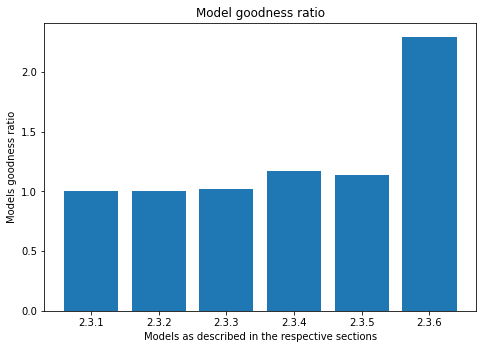

In [82]:
import plotly.express as px
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ["2.3.1", "2.3.2", "2.3.3", "2.3.4", "2.3.5", "2.3.6"]
goodness = [model_goodness_1, model_goodness_2, model_goodness_3, model_goodness_4, model_goodness_5, model_goodness_6]
ax.bar(models,goodness)
ax.set_xlabel('Models as described in the respective sections')
ax.set_ylabel('Models goodness ratio')
ax.set_title('Model goodness ratio')
plt.show()


2.3.1) Rhythm similarity measured with cosine simularity, using tresillo template as centre.<br>
2.3.2) Rhythm similarity measured with inverse euclidean distance, using tresillo template as centre. <br>
2.3.3) Rhythm similarity measured with cosine simularity, using the centroid of tresillo songs as centre.<br>
2.3.4) Rhythm similarity measured with inverse euclidean distance, using the centroid of tresillo songs as centre.<br>
2.3.5) Rhythm similarity measured with parameterized cosine simularity, using the centroid of tresillo songs as centre.<br>
2.3.6) Rhythm similarity measured with parameterized cosine simularity, using tresillo template as centre.<br>

### 3.4) Tresilio-ness over Time

Now that we explored several ways to compute Tresillo-ness, we can calculate the Tresilo-ness of our billboard data set.  
First let us load the rhythm vectors of our billboard songs and let's also merge it to the metadata of the billboard songs.  
The metadata of the billboard songs includes time signatures with which we can Tresillo-ness over time.

In [98]:
df_billboard = pd.read_csv(home_dir + 'dataset/rythm_vectors/rythm_vectors_billboard.csv')
df_billboard_meta = pd.read_csv(home_dir + 'dataset/billboard_1999-2019_unique_top_20_selection.csv')

#calculate cosine simularity
df_billboard = collapse_normalize_vectors(df_billboard)
df_billboard_sim = calc_cosine_sim(df_billboard, vector_vanilla_tresillo, model)

#prepare for merge with meta data
df_billboard_sim['song_artist'] = df_billboard_sim.index
df_billboard_sim['song'] = df_billboard_sim.song_artist.apply(lambda x: x.split('_')[0])
df_billboard_sim['artist'] = df_billboard_sim.song_artist.apply(lambda x: x.split('_')[1][:-1])
df_billboard_sim = df_billboard_sim.drop(['song_artist'], axis=1)

#merge data frames
df_billboard_merged = df_billboard_sim.merge(df_billboard_meta, left_on=['song','artist'], right_on=['Name', 'Artists'], how='left')
df_billboard_reduced = df_billboard_merged[['Name', 'Artists', 'Peak.position', 'Week', 'Genre', 'cosine_sim_tresillo']]
#let's look at some songs with very high tresillo-ness
df_billboard_reduced[df_billboard_reduced['cosine_sim_tresillo']>0.80]


,Name,Artists,Peak.position,Week,Genre,cosine_sim_tresillo
89,Cheap Thrills,Sia,19.0,2016-06-18,"Jamaica,Remix,Australia,Rap,Synth-Pop,Pop",0.848693
389,Turn Me On,Kevin Lyttle,20.0,2004-06-23,Pop,0.902922
423,Where Have You Been,Rihanna,18.0,2012-05-25,"House,Electro-Pop,Pop",0.915672


Let's plot weekly cosine Tresillo-ness 

Text(0, 0.5, 'Cosine Tresillo-ness')

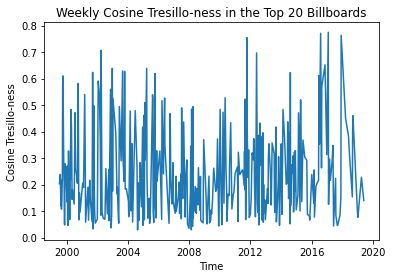

In [99]:
df_bilboard_merged_weekly = df_billboard_merged.groupby(['Week'])['cosine_sim_tresillo'].agg(['mean']).reset_index()
plt.plot(pd.to_datetime(df_bilboard_merged_weekly.Week), df_bilboard_merged_weekly['mean'])
plt.title('Weekly Cosine Tresillo-ness in the Top 20 Billboards')
plt.xlabel('Time')
plt.ylabel('Cosine Tresillo-ness')

The time trend above is very noisy and hard to read. By calculating a 4 weeks moveing average we might get smoother results.

Text(0, 0.5, 'Cosine Tresillo-ness')

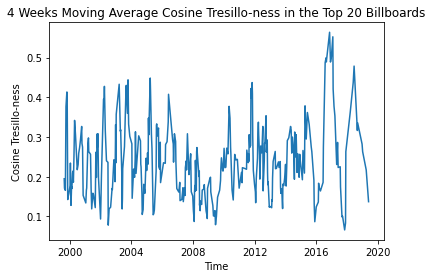

In [100]:
df_bilboard_merged_weekly['rolling_mean'] = df_bilboard_merged_weekly.iloc[:,1].rolling(window=4).mean()

plt.plot(pd.to_datetime(df_bilboard_merged_weekly.Week), df_bilboard_merged_weekly['rolling_mean'])
plt.title('4 Weeks Moving Average Cosine Tresillo-ness in the Top 20 Billboards')
plt.xlabel('Time')
plt.ylabel('Cosine Tresillo-ness')

**TA instructions**: 
- Present your results in relation to your research question.
- Present them in a logical order that does not have to be the order in which you achieved them.

**Thoughts Aurel:** 

 4. Discussion of the clustering method, either k-mean clustering or something we dont have to set the cluster number
 5. Finding Tresillio-ness in the pop charts with all three methods a) Vanilla Tresillio-ness b) Tresillio songs vector c) 
 
    

## 4) Outlook on final interpretation

Points to discuss as stated by TAs: 
- Interpreting your results is the final step that you will do in preparing Milestone 4 (your presentations). Please end your submission by giving a first,preliminary outlook on this final step: what aspects of your results do you find interesting with respect to your hypotheses and previous literature? What do you think might be the main points to elaborate upon in the discussion? 

 * No such trend but peaks
 * Argue of correctness

## References

- Chin,  F.  and  Wu,  S.  (1992).   An  efficient  algorithm  for  rhythm-finding.Computer MusicJournal, 16(2):35–44.
- Dixon,  S.,  Gouyon,  F.,  Widmer,  G.,  et  al.  (2004).   Towards  characterisation  of  music  viarhythmic patterns.  InISMIR.
- Huron, D. and Ommen, A. (2006).  An empirical study of syncopation in american popularmusic, 1890–1939.Music Theory Spectrum, 28(2):211–231.
- Palmer, C. and Krumhansl, C. L. (1990).  Mental representations for musical meter.Journalof Experimental Psychology: Human Perception and Performance, 16(4):728.
- Panteli,  M.,  Bogaards,  N.,  Honingh,  A.  K.,  et  al.  (2014).   Modeling  rhythm  similarity  forelectronic dance music.  InISMIR, pages 537–542.
- Parry, M. and Essa, I. (2003).  Rhythmic similarity through elaboration.
- Pohle,  T.,  Schnitzer,  D.,  Schedl,  M.,  Knees,  P.,  and  Widmer,  G.  (2009).   On  rhythm  andgeneral music similarity.  InISMIR, pages 525–530. 
- Rohrmeier, M. (2020).  Towards a formalization of musical rhythm.  InProc. of the 21st Int.Society for Music Information Retrieval Conf
- Floyd, Samuel A. "Black music in the circum-Caribbean." American Music (1999): 5-7.
- Toussaint, Godfried. "The geometry of musical rhythm." Japanese Conference on Discrete and Computational Geometry. Springer, Berlin, Heidelberg, 2004, page 199.